## Objective

#### Forecasting future sales of gifts shop using Training data on 2009-10 and predicting on 2010-11.

Steps:
1. Data Extraction in the form of dataframe
2. Exploratory Data Analysis: 
    1. Finding missing dates
    2. Filling them with rolling mean/backward/forward fill
    3. Finding nan for all columns
    4. Developing new column i.e sales using Quantity and Price.
3. Data Visualization:
    1. Plot Time vs Sales to see seasonality/trend
    2. Check for stationarity using Dikki Fuller Test and rolling statistics
    3. Make the data stationary using Transformation like Differencing, Log transformation
4. Modelling using ARIMA or SARIMAX:
    1. Finding p, d, q usig pacf and acf plots
    2. Model fitting and Prediction
    3. Checking AIC and Pvalues(< 0.05)




In [36]:
## Importing required packages/libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16,10
import scipy.stats as stats

In [37]:
## Extracting data in the form of dataframe from sheet name-Year 2009-2010
sales_train_df= pd.read_excel('online_retail_II.xlsx', engine='openpyxl', sheet_name='Year 2009-2010')
print(sales_train_df.head())


  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


In [38]:
## Calculating number of rows and columns in the dataset
sales_train_df.shape

(525461, 8)

In [39]:
## Extracting Test data into dataframe from sheet name-Year 2010-2011
sales_test_df= pd.read_excel('online_retail_II.xlsx', engine='openpyxl', sheet_name='Year 2010-2011')
print(sales_test_df.head())

  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  


EDA- Exploratory Data Analysis 

In [40]:
# General Function to calculate missing dates and no. of missing dates in the date column from the dataset
from datetime import datetime,date
def missing_dates(df, col_date):
    df['Date_n'] = pd.to_datetime(df[col_date]).dt.date
    strt_dt = df['Date_n'].values[0].strftime('%Y-%m-%d')
    end_dt = df['Date_n'].values[-1].strftime('%Y-%m-%d')
    missing_dates = pd.date_range(start=strt_dt, end=end_dt).difference(df['Date_n']).strftime('%Y-%m-%d').tolist()
    length_missing = len(missing_dates)
    return missing_dates, length_missing

In [41]:
#Calculate missing dates and no. of missing dates for sales dataset
salesdf = sales_train_df.copy(deep = False)
Dates_missing, Total_missing_dates = missing_dates(salesdf, 'InvoiceDate')
print("All missing dates in the dataset:\n", Dates_missing, "\nNo. of missing dates:", Total_missing_dates)

All missing dates in the dataset:
 ['2009-12-12', '2009-12-19', '2009-12-24', '2009-12-25', '2009-12-26', '2009-12-27', '2009-12-28', '2009-12-29', '2009-12-30', '2009-12-31', '2010-01-01', '2010-01-02', '2010-01-03', '2010-01-09', '2010-01-16', '2010-01-23', '2010-01-30', '2010-02-06', '2010-02-13', '2010-02-20', '2010-02-27', '2010-03-06', '2010-03-13', '2010-03-20', '2010-03-27', '2010-04-02', '2010-04-03', '2010-04-04', '2010-04-05', '2010-04-10', '2010-04-17', '2010-04-24', '2010-05-01', '2010-05-03', '2010-05-08', '2010-05-15', '2010-05-22', '2010-05-29', '2010-05-31', '2010-06-05', '2010-06-12', '2010-06-19', '2010-06-26', '2010-07-03', '2010-07-10', '2010-07-17', '2010-07-24', '2010-07-31', '2010-08-07', '2010-08-14', '2010-08-21', '2010-08-28', '2010-08-30', '2010-09-04', '2010-09-11', '2010-09-18', '2010-09-25', '2010-10-02', '2010-10-09', '2010-10-16', '2010-10-23', '2010-10-30', '2010-11-06', '2010-11-13', '2010-11-20', '2010-11-27', '2010-12-04'] 
No. of missing dates: 67


In [42]:
#checking negative values in Quantity and Price
salesdf[salesdf.Quantity < 0].shape[0]

12326

In [43]:
salesdf[salesdf.Price < 0].shape[0]

3

In [44]:
salesdf.Quantity = salesdf.Quantity.abs()
salesdf.Price = salesdf.Price.abs()

In [45]:
# Dataframe to define the range of dates between two dates in datetime64[ns] format
idx = pd.date_range(start=min(salesdf.Date_n) , end=max(salesdf.Date_n))
# print(min(salesdf.Date_n),max(salesdf.Date_n) )
# print(idx) 
idx = pd.DataFrame(idx, columns=['Date_n'])
#print(idx.astype('datetime64[ns]'))
# print(idx.dtypes)

In [46]:
## Calculating sales based on quantity and Price
salesdf['Sales'] = salesdf['Quantity'] * salesdf['Price']
salesdf.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date_n,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009-12-01,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009-12-01,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009-12-01,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01,30.0


In [47]:
## Value count on sales to check whether all values in Sales are integer type and not str type.
#sales_train_df['Sales'].value_counts()

In [48]:
#missing values in all columns except date
def missing_vals(df, col_list):
    for i in col_list:
        print(i, "has",df[i].isna().sum(), "nan values")
    

In [49]:
col_lst = ['Invoice', 'StockCode', 'Description', 'Quantity', 'Price', 'Customer ID', 'Country']
missing_vals(salesdf, col_lst)

Invoice has 0 nan values
StockCode has 0 nan values
Description has 2928 nan values
Quantity has 0 nan values
Price has 0 nan values
Customer ID has 107927 nan values
Country has 0 nan values


In [50]:
# Grouping Date and Sales column using DateTimeIndex and groupby function and then merging this grouped dataframe with that dataframe
#  which defines the range of dates between min and max dates for that dataset.
sum_sales_train_df = pd.merge(idx, salesdf.groupby(pd.DatetimeIndex(salesdf['Date_n']))['Sales'].sum().reset_index(), how="left", on=["Date_n"])
print(sum_sales_train_df.Sales.isna().sum())

67


In [51]:
# Fill Sales with rolling mean
sum_sales_train_df['Sales']= sum_sales_train_df['Sales'].fillna(sum_sales_train_df['Sales'].fillna(0).rolling(window =5).mean())
sum_sales_train_df.Sales.isna().sum()

0

In [52]:
sumsales = sum_sales_train_df[['Date_n', 'Sales']]
indexed_sumsales = sumsales.set_index(['Date_n'])
indexed_sumsales


,Sales
Date_n,
2009-12-01,55853.97
2009-12-02,63941.43
2009-12-03,79982.77
2009-12-04,41119.44
2009-12-05,9803.05
...,...
2010-12-05,32165.95
2010-12-06,55800.74
2010-12-07,154177.35


In [53]:
#Filling nan values with forward fill
#indexed_sumsales['Sales']=indexed_sumsales['Sales'].fillna(method="ffill")
#indexed_sumsales.Sales.isnull().sum()

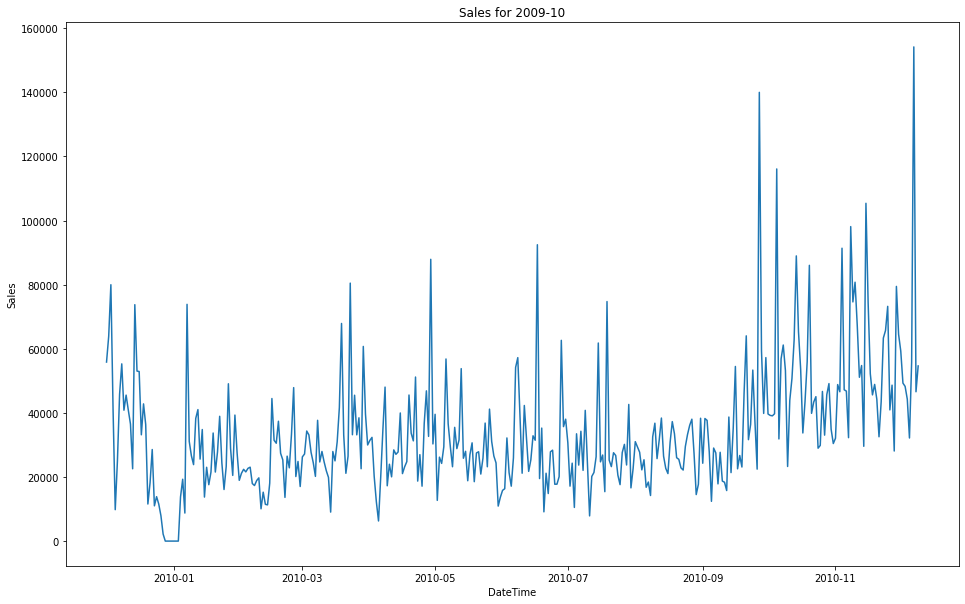

In [54]:
## Visualizing Sales Data
plt.xlabel('DateTime')
plt.ylabel('Sales')
plt.title('Sales for 2009-10')
plt.plot(indexed_sumsales['Sales'])
plt.show()

In [55]:
## Determing rolling statistics
rolmean = indexed_sumsales['Sales'].rolling(window = 12).mean()
rolstd = indexed_sumsales['Sales'].rolling(window = 12).std()
print(rolmean, rolstd)

Date_n
2009-12-01             NaN
2009-12-02             NaN
2009-12-03             NaN
2009-12-04             NaN
2009-12-05             NaN
                  ...     
2010-12-05    52826.576500
2010-12-06    51999.549833
2010-12-07    58744.810667
2010-12-08    59216.033167
2010-12-09    59715.355667
Name: Sales, Length: 374, dtype: float64 Date_n
2009-12-01             NaN
2009-12-02             NaN
2009-12-03             NaN
2009-12-04             NaN
2009-12-05             NaN
                  ...     
2010-12-05    15881.239998
2010-12-06    15399.582985
2010-12-07    33100.436447
2010-12-08    32863.251641
2010-12-09    32733.353542
Name: Sales, Length: 374, dtype: float64


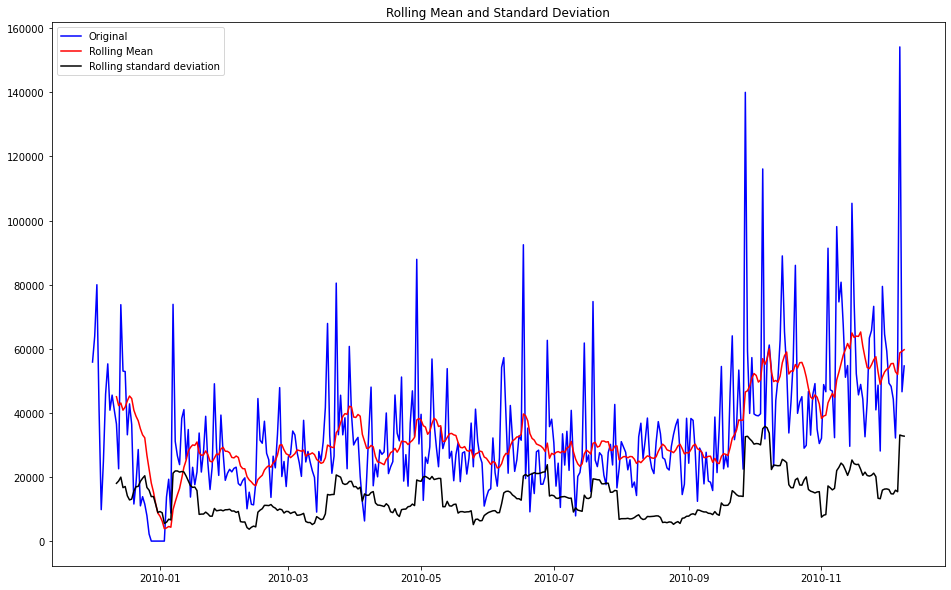

In [56]:
#Plot rolling statistics
orig = plt.plot(indexed_sumsales['Sales'], color = 'blue', label='Original')
mean = plt.plot(rolmean, color = 'red', label='Rolling Mean')
std = plt.plot(rolstd, color = 'black', label='Rolling standard deviation')
plt.legend(loc = 'best')
plt.title('Rolling Mean and Standard Deviation')
plt.show(block=False)

##### ADF(Augmented Dickey Fuller Test)

A time series is said to be stationary if its statistical properties do not change with time.
The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. It checks if your time series is stationary or not. A stationary time series is one whose statistical properties such as mean, variance, autocorrelation, are all constant over time. Such statistics are useful as descriptors of future behavior only if the series is stationary.

The hypotheses for the test:
The null hypothesis for this test is that the time series is non-stationary.
The alternate hypothesis for this test is that the time series is stationary.

If ADF statistic < Critical Value, Reject the null Hypothesis otherwise fail to reject or accept the null hypothesis.


In [57]:
# Code for Dikki Fuller Test in the form of Function
#Ho: It is non stationary
#H1: It is stationary
from statsmodels.tsa.stattools import adfuller
def adfuller_test(df):
    result=adfuller(df)
    print('Results of Dikki Fuller Test:')
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('Critical Values:')
    for k, val in result[4].items():
        print('\t%s: %.3f' % (k, val))
        
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [58]:
adfuller_test(indexed_sumsales['Sales'])


Results of Dikki Fuller Test:
ADF Test Statistic : -2.156097248620785
p-value : 0.22256351407434716
#Lags Used : 13
Number of Observations Used : 360
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [70]:
#Visualizing Sales Data
#indexed_sumsales.plot(figsize=(14,8), title='Sales for 2009-10')

In [61]:
#Trying to test stationarity by ourselves by using Sales column and using a regression model with target variable 
# being difference between two rows and independent variable being the actual Sales

In [62]:
#New column named as Diff_Value is made using the difference between two consecutive values of Sales
indexed_sumsales["Diff_Value"] = indexed_sumsales["Sales"].diff()
#print(indexed_sumsales.head(), "\n")

#Target variable is set by applying filter on Diff_Value to remove all nan values but it includes only one nan which was generated
# after difference calculation.
diff_values = indexed_sumsales["Diff_Value"].values
Target = diff_values[~np.isnan(diff_values)]
#print(Target, "\n")

#Then independent variable i.e sales values are taken by removing last value as one nan value was removed from Target so to match 
# the total number of independent values with Target values, we have done this.
inde_values = indexed_sumsales["Sales"].values
ind_vals = inde_values[:-1]
#print(ind_vals, "\n")

#Constant is added using add_constant of statsmodels.api
import statsmodels.api as sm
X = sm.add_constant(ind_vals)

#Model is generated using OLS i.e Ordinary Least Square Method and results are obtained by fitting the model.
model = sm.OLS(Target,X)
results = model.fit()

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     157.0
Date:                Fri, 14 Jan 2022   Prob (F-statistic):           2.84e-30
Time:                        20:20:02   Log-Likelihood:                -4185.7
No. Observations:                 373   AIC:                             8375.
Df Residuals:                     371   BIC:                             8383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.018e+04   1864.308     10.822      0.0

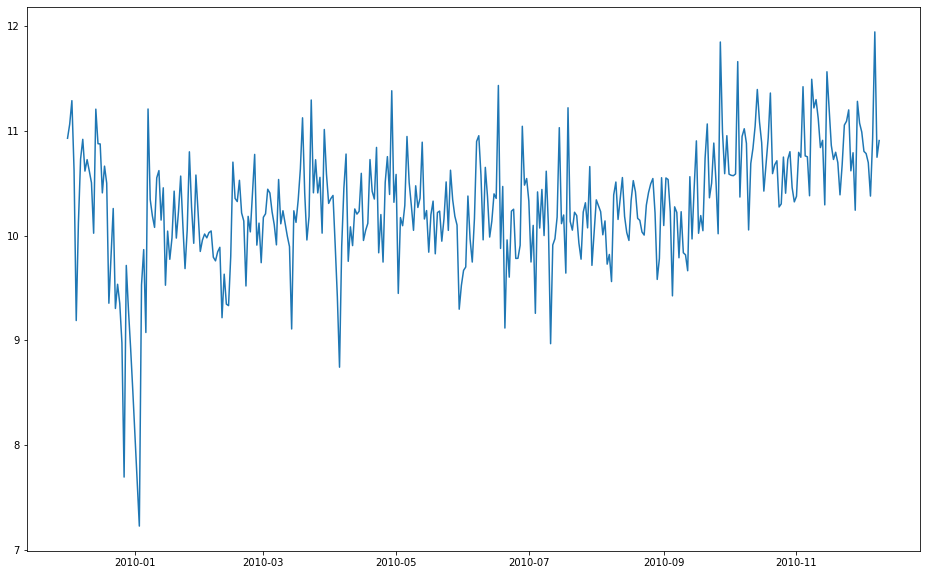

In [132]:
log_sum_sales_traindf = np.log(indexed_sumsales['Sales'])
log_sum_sales_traindf = log_sum_sales_traindf.replace([np.inf, -np.inf], np.nan)
log_sum_sales_traindf = log_sum_sales_traindf.fillna(log_sum_sales_traindf.fillna(0).rolling(window =25).mean())
plt.plot(log_sum_sales_traindf)

In [133]:
# np.isinf(log_sum_sales_traindf).values.sum()

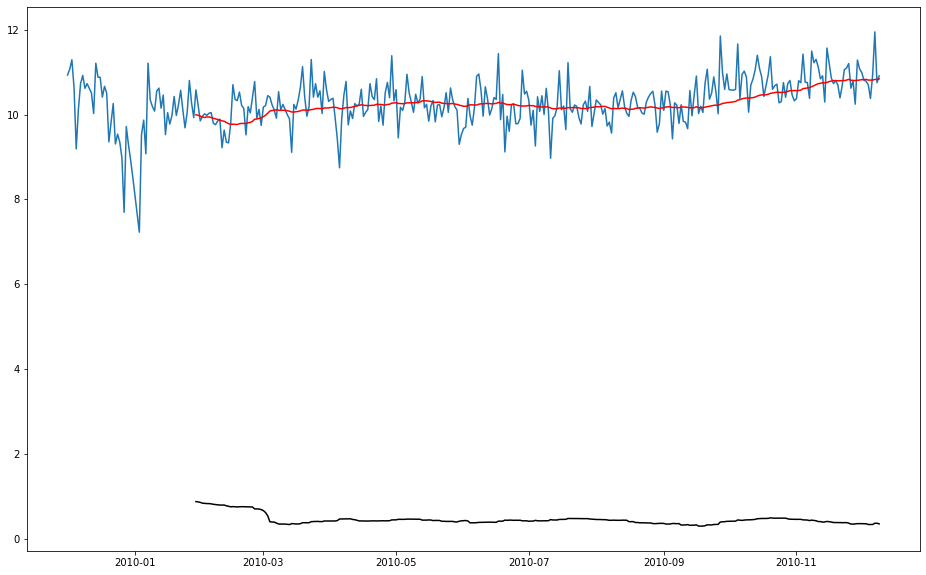

In [134]:
movingAverage = log_sum_sales_traindf.rolling(window=60).mean()
movingSTD = log_sum_sales_traindf.rolling(window=60).std()
plt.plot(log_sum_sales_traindf)
plt.plot(movingAverage, color='red', label='movingAverage')
plt.plot(movingSTD, color='black', label='movingSTD')

In [135]:
logScaleMinusmovingAverage = log_sum_sales_traindf - movingAverage
logScaleMinusmovingAverage.head(12)

#Remove Nan values
logScaleMinusmovingAverage.dropna(inplace=True)
logScaleMinusmovingAverage.head(10)

Date_n
2010-01-29    0.585090
2010-01-30    0.241718
2010-01-31   -0.112218
2010-02-01    0.019055
2010-02-02    0.086429
2010-02-03    0.036964
2010-02-04    0.088251
2010-02-05    0.115775
2010-02-06   -0.116171
2010-02-07   -0.136737
Name: Sales, dtype: float64

In [136]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, win):
    
    ## Determing rolling statistics
    movingAvg = timeseries.rolling(window = win).mean()
    movingStd= timeseries.rolling(window = win).std()

    #Plot rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label='Original')
    mean = plt.plot(movingAvg, color = 'red', label='Rolling Mean')
    std = plt.plot(movingStd, color = 'black', label='Rolling standard deviation')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #Perform Dikki Fuller Test
    result=adfuller(timeseries, autolag='AIC')
    print('Results of Dikki Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : %.3f  '% (value) )
    print('Critical Values:')
    for k, val in result[4].items():
        print('\t%s: %.3f' % (k, val))
        
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

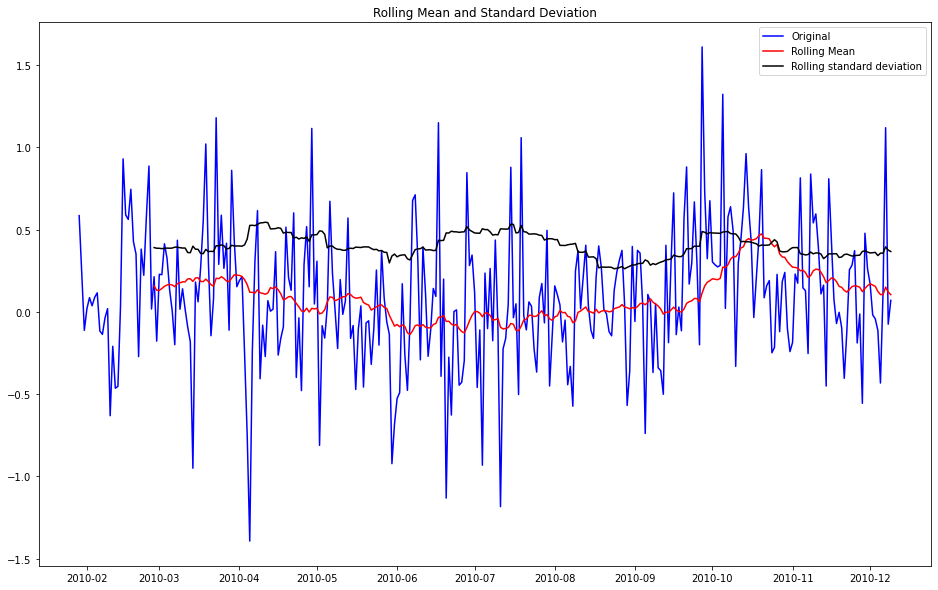

Results of Dikki Fuller Test:
ADF Test Statistic : -3.687  
p-value : 0.004  
#Lags Used : 14.000  
Number of Observations Used : 300.000  
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [137]:
test_stationarity(logScaleMinusmovingAverage,30)

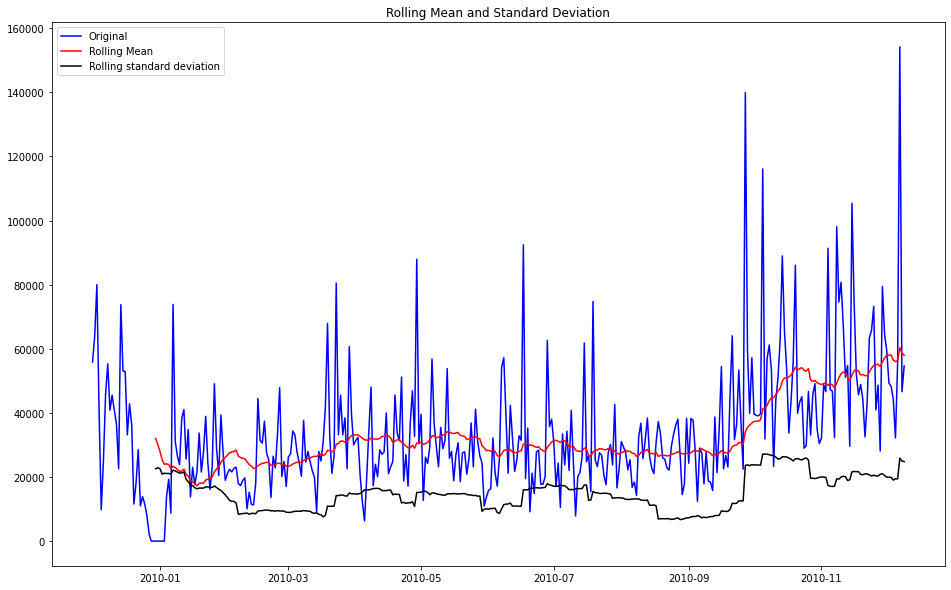

Results of Dikki Fuller Test:
ADF Test Statistic : -2.156  
p-value : 0.223  
#Lags Used : 13.000  
Number of Observations Used : 360.000  
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [94]:
test_stationarity(indexed_sumsales['Sales'],30)


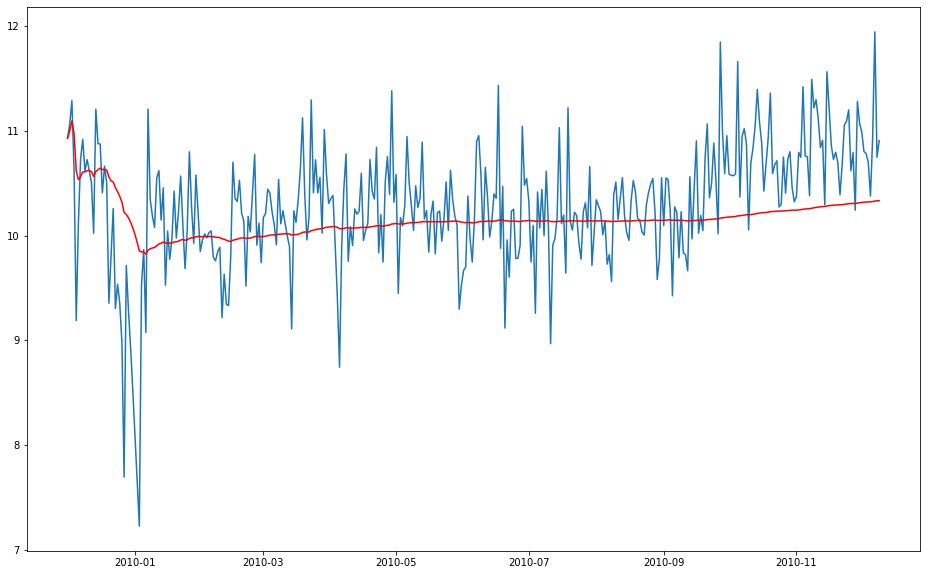

In [138]:
#Weighted Average of timeseries so to see the trend
exponentialDecayWeightedAverage = log_sum_sales_traindf.ewm(halflife=365, min_periods=0, adjust=True).mean()

plt.plot(log_sum_sales_traindf)
plt.plot(exponentialDecayWeightedAverage, color ='red')

In [139]:
np.isinf(log_sum_sales_traindf).values.sum()

0

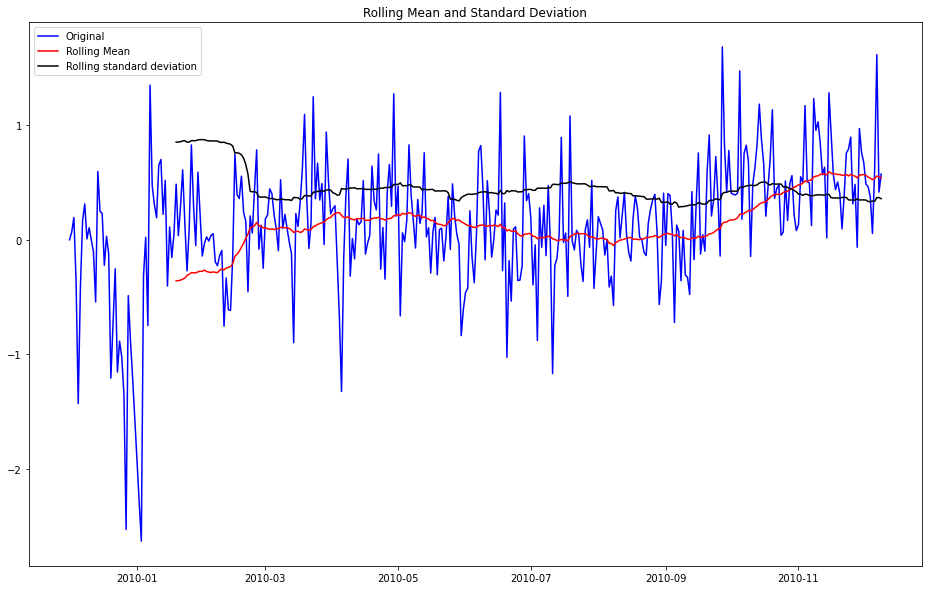

Results of Dikki Fuller Test:
ADF Test Statistic : -3.123  
p-value : 0.025  
#Lags Used : 14.000  
Number of Observations Used : 359.000  
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [141]:
logScaleMinusexponentialDecayWeightedAverage = log_sum_sales_traindf - exponentialDecayWeightedAverage
logScaleMinusexponentialDecayWeightedAverage.dropna(inplace=True)
test_stationarity(logScaleMinusexponentialDecayWeightedAverage, 50)

Differencing

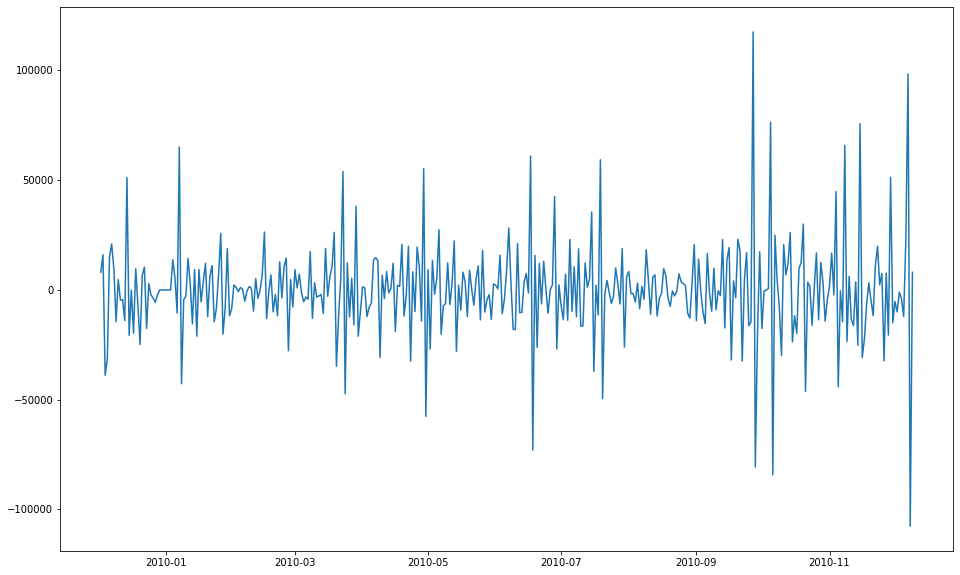

In [144]:
sumSalesdf =  indexed_sumsales['Sales'] 
sumSalesDiffShifting = sumSalesdf - sumSalesdf.shift(1)
# y1=y1[1:]
# print(y1)
# y1.plot()
plt.plot(sumSalesDiffShifting)
# res = adfuller(y1)
# print('p-value: %f' % res[1])
# print('Augmented Dickey Fuller(ADF) Statistic: %f' % res[0])
# print('Critical Values:')
# for k, val in res[4].items():
#     print('\t%s: %.3f' % (k, val))

# if res[0] < res[4]["5%"]:
#     print ("Reject Null Hypothesis - Time Series is Stationary")
# else:
#     print ("Failed to Reject Null Hypothesis - Time Series is Non-Stationary")

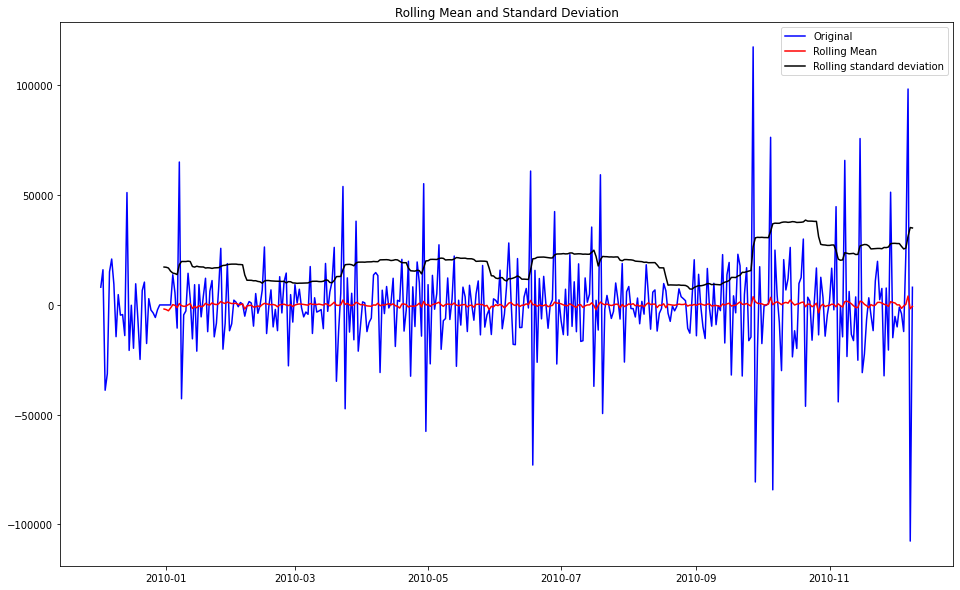

Results of Dikki Fuller Test:
ADF Test Statistic : -7.666  
p-value : 0.000  
#Lags Used : 12.000  
Number of Observations Used : 360.000  
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [147]:
sumSalesDiffShifting.dropna(inplace=True)
test_stationarity(sumSalesDiffShifting,30)

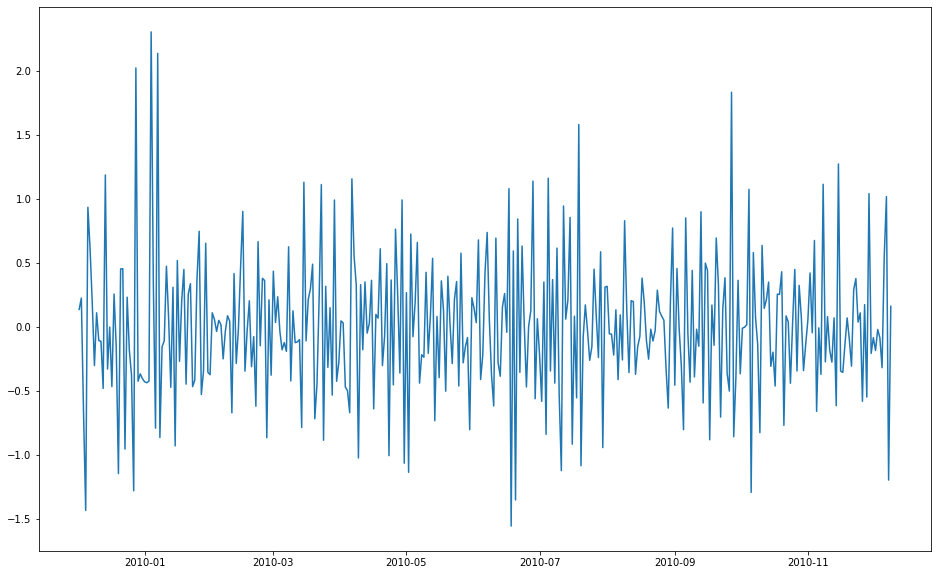

In [148]:
logSalesDiffShifting = log_sum_sales_traindf - log_sum_sales_traindf.shift(1)
plt.plot(logSalesDiffShifting)

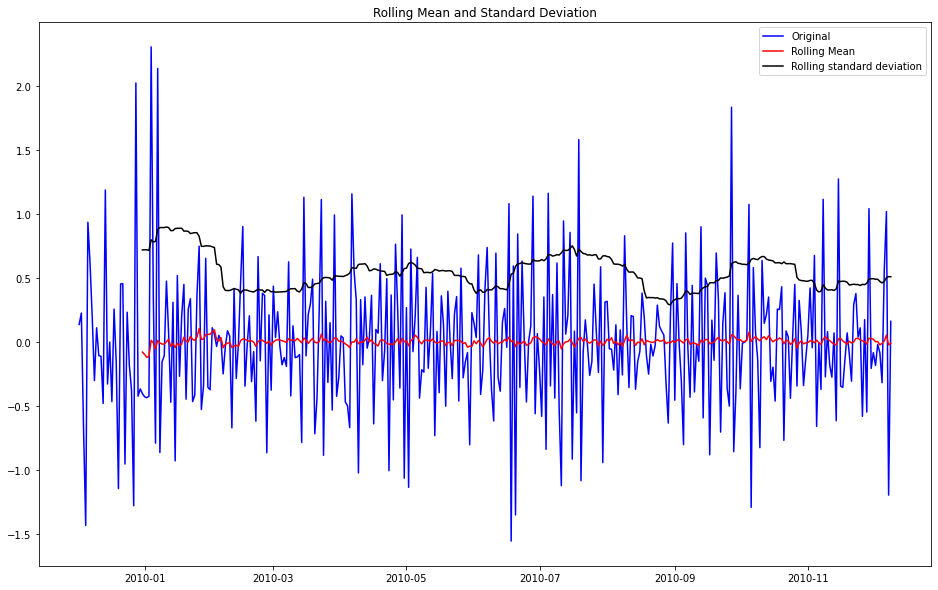

Results of Dikki Fuller Test:
ADF Test Statistic : -6.298  
p-value : 0.000  
#Lags Used : 17.000  
Number of Observations Used : 355.000  
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [150]:
logSalesDiffShifting.dropna(inplace=True)
test_stationarity(logSalesDiffShifting,30)

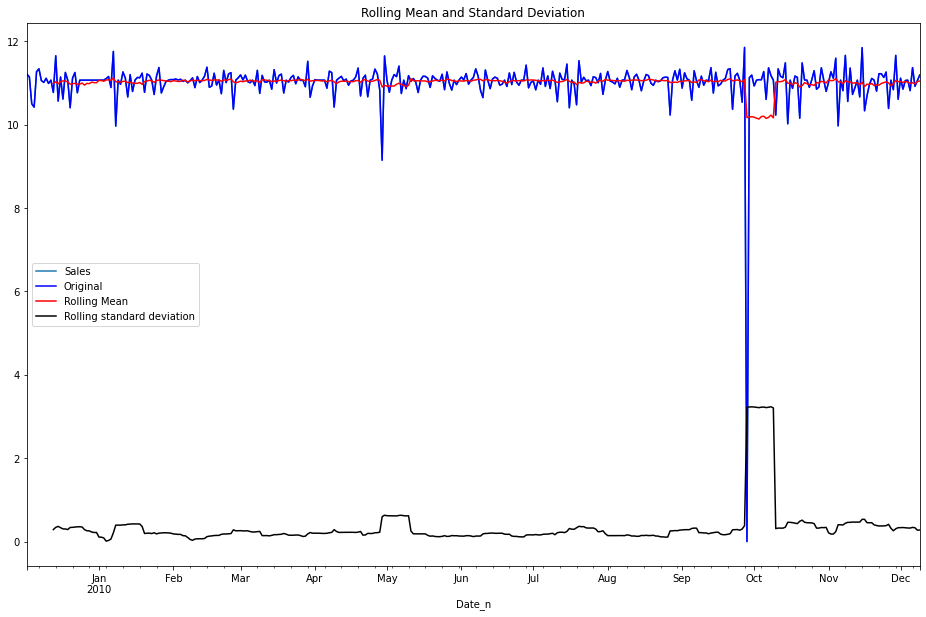

Results of Dikki Fuller Test:
ADF Test Statistic : -21.988  
p-value : 0.000  
#Lags Used : 0.000  
Number of Observations Used : 372.000  
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
y2 = np.log(sumSalesDiffShifting-np.min(sumSalesDiffShifting)+1)
y2.plot()
test_stationarity(y2)
# res = adfuller(y2)
# print('p-value: %f' % res[1])
# print('Augmented Dickey Fuller(ADF) Statistic: %f' % res[0])
# print('Critical Values:')
# for k, val in res[4].items():
#     print('\t%s: %.3f' % (k, val))

# if res[0] < res[4]["5%"]:
#     print ("Reject Null Hypothesis - Time Series is Stationary")
# else:
#     print ("Failed to Reject Null Hypothesis - Time Series is Non-Stationary")

Auto Regressive Model

<img src="Image.PNG">

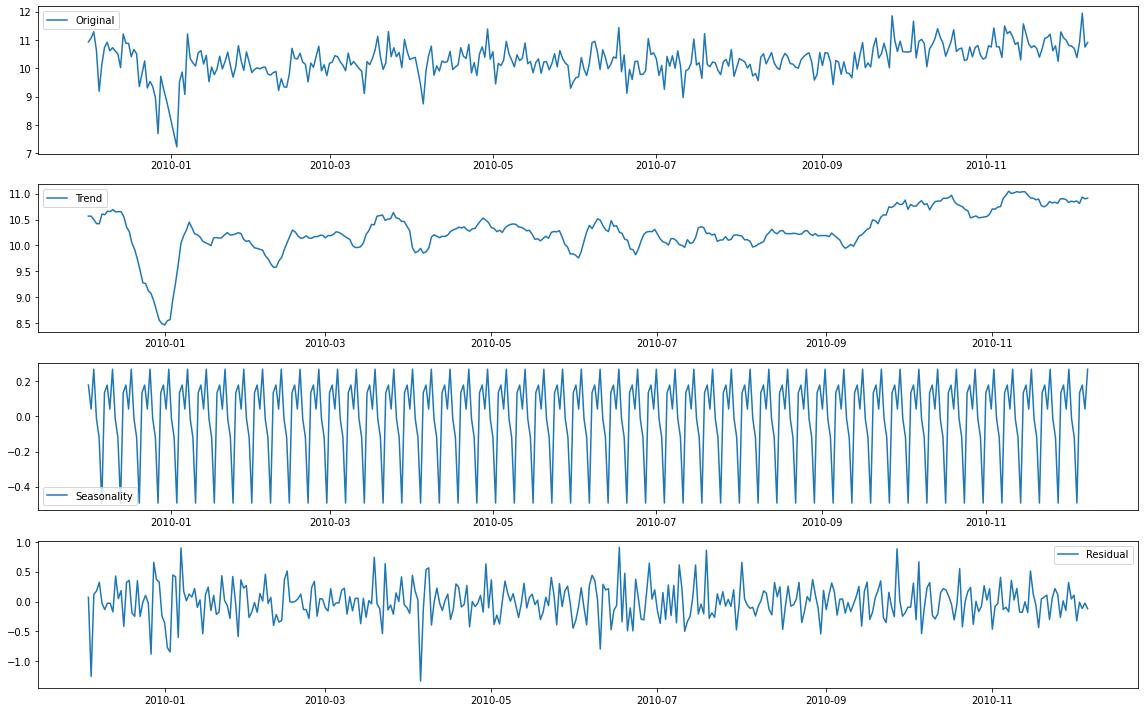

In [152]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(log_sum_sales_traindf)

trnd = decomposition.trend
seasonl = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(log_sum_sales_traindf, label ='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trnd, label ='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonl, label ='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label ='Residual')
plt.legend(loc='best')
plt.tight_layout()



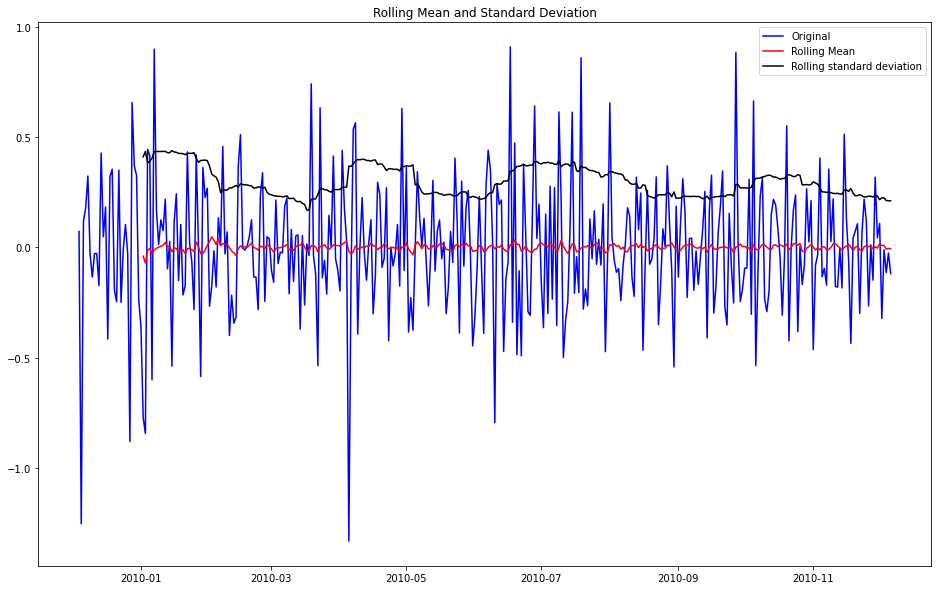

Results of Dikki Fuller Test:
ADF Test Statistic : -12.128  
p-value : 0.000  
#Lags Used : 8.000  
Number of Observations Used : 359.000  
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [154]:
decomposedlogData = residual
decomposedlogData.dropna(inplace=True)
test_stationarity(decomposedlogData,30)

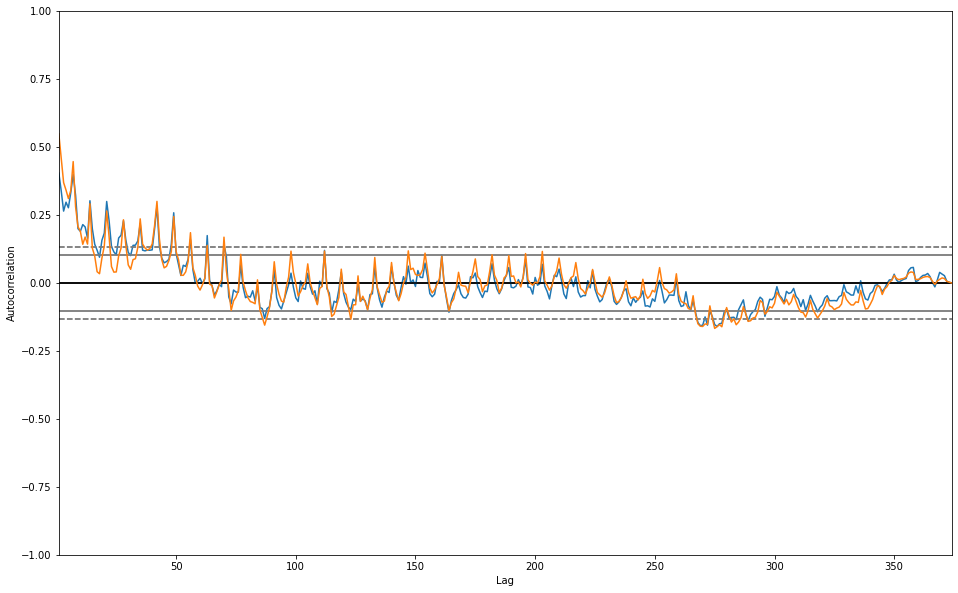

In [156]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(indexed_sumsales['Sales'])
autocorrelation_plot(log_sum_sales_traindf)
plt.show()

Final Thoughts on Autocorrelation and Partial Autocorrelation

Identification of an AR model is often best done with the PACF.
For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

p,d,q p AR model lags d differencing q MA lags

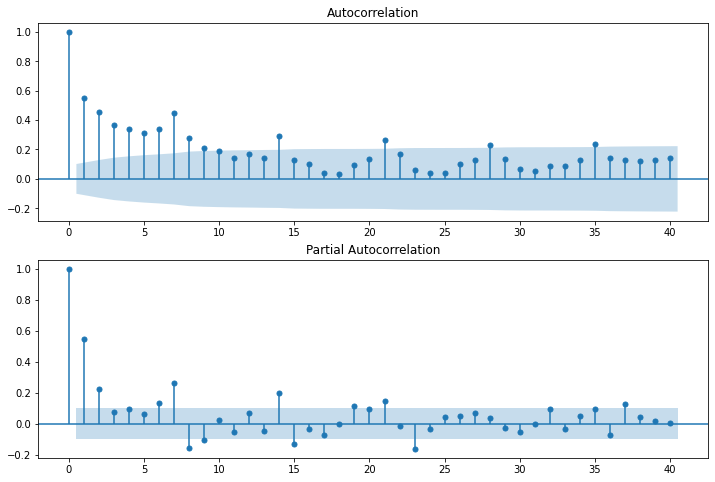

In [157]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(log_sum_sales_traindf,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(log_sum_sales_traindf,lags=40,ax=ax2)

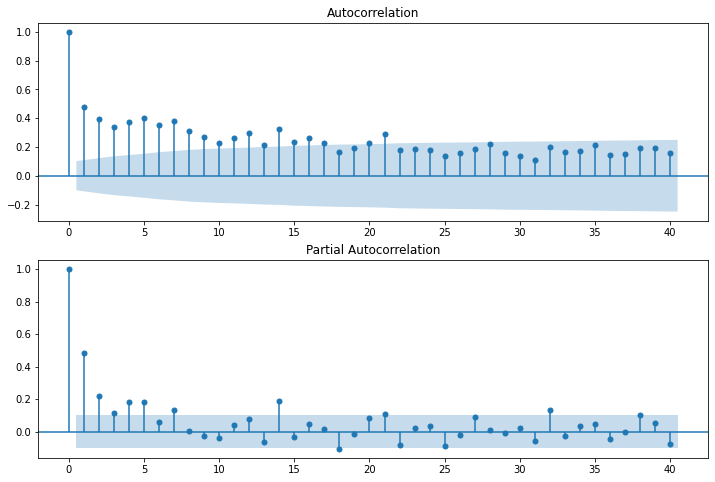

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(sum_sales_train_df['Sales'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(sum_sales_train_df['Sales'],lags=40,ax=ax2)

In [158]:
# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(211)
# fig = plot_acf(y1,lags=40,ax=ax1)
# ax2 = fig.add_subplot(212)
# fig = plot_pacf(y1,lags=40,ax=ax2)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(sum_sales_train_df['Sales'],order=(5,1,1))
model_fit=model.fit()
model_fit.summary()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(sum_sales_train_df['Sales'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

C:\Users\saksh\.conda\envs\sales\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\saksh\.conda\envs\sales\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  373
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4063.526
Method:                       css-mle   S.D. of innovations          13011.055
Date:                Thu, 13 Jan 2022   AIC                           8135.052
Time:                        16:29:29   BIC                           8150.738
Sample:                             1   HQIC                          8141.281
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            18.9964     94.156      0.202      0.840    -165.546     203.539
ar.L1.D.Sales     0.1645      0.066      2.486      0.013       0.035       0.294
ma.L1.D.Sales    -0.8863      0.038    -23.409      0.000      -0.961      -0.812
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.0774           +0.0000j            6.0774            0.0000
MA.1            1.1283           +0.0000j            1.1283            0.0000
-----------------------------------------------------------------------------
"""

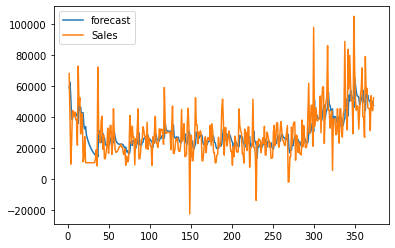

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.show()

C:\Users\saksh\.conda\envs\sales\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\saksh\.conda\envs\sales\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.ts

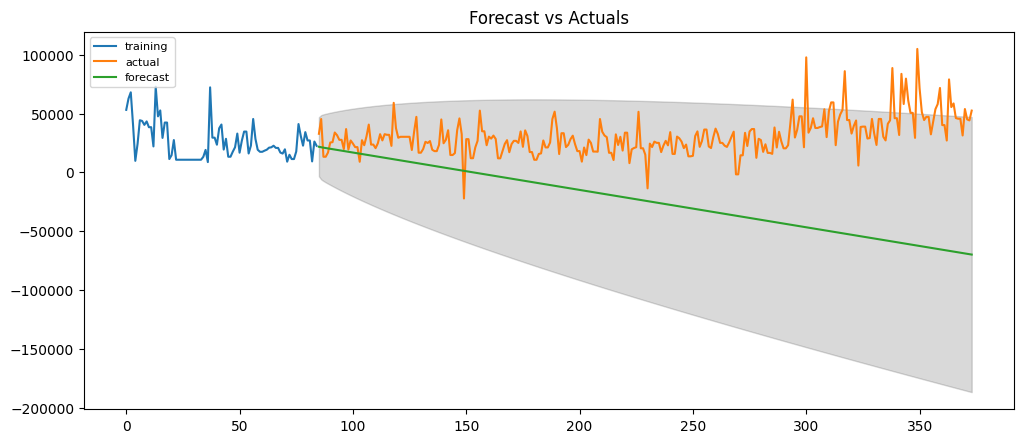

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = sum_sales_train_df.Sales[:85]
test = sum_sales_train_df.Sales[85:]

# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(289, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                   85
Model:                     ARMA(1, 2)   Log Likelihood                -923.813
Method:                       css-mle   S.D. of innovations          12663.801
Date:                Thu, 13 Jan 2022   AIC                           1857.626
Time:                        16:29:30   BIC                           1869.839
Sample:                             0   HQIC                          1862.538
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.719e+04   4831.456      5.628      0.000    1.77e+04    3.67e+04
ar.L1.Sales     0.8766      0.102      8.595      0.000       0.677       1.077
ma.L1.Sales    -0.4880      0.151     -3.228    

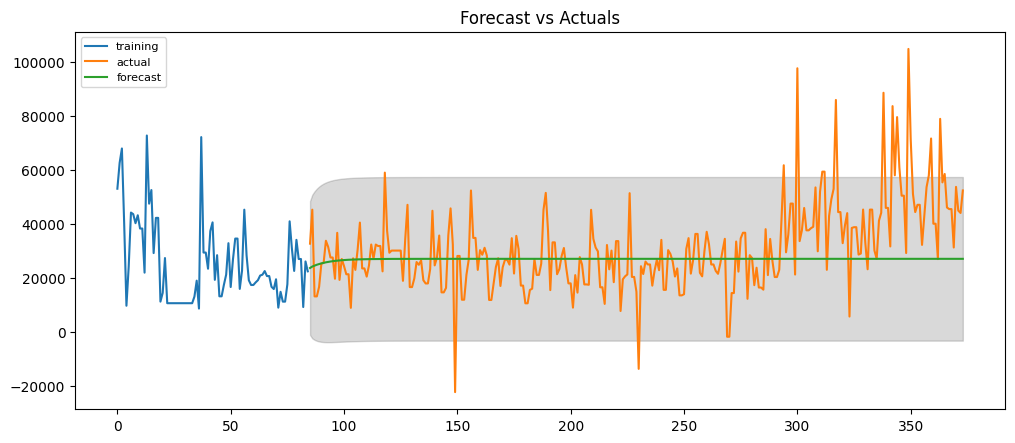

In [ ]:
# Build Model
model = ARIMA(train, order=(1,0,2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(289, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)


C:\Users\saksh\.conda\envs\sales\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\saksh\.conda\envs\sales\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


{'mape': 0.5040013534163215,
 'me': -4004.672951192645,
 'mae': 11385.429779196938,
 'mpe': -0.08075446844908753,
 'rmse': 16416.997685053495,
 'acf1': 0.4633329577808936,
 'corr': 0.0666705065478945,
 'minmax': 0.2918138103274619}

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm


model = pm.auto_arima(sum_sales_train_df.Sales, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8166.218, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8865.511, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8293.358, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8676.179, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8163.121, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=8234.325, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=8165.012, Time=0.21 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8161.141, Time=0.45 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8159.705, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8617.544, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8160.590, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=8602.779, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8162.407, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8178.876, Time=0.10 sec

Best model:  ARIMA(1,0,2)(0,0,0)

In [ ]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(sum_sales_train_df['Sales'],order=(1, 0, 2),seasonal_order=(1,0,2,12))
res=model.fit()

C:\Users\saksh\.conda\envs\sales\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<AxesSubplot:>

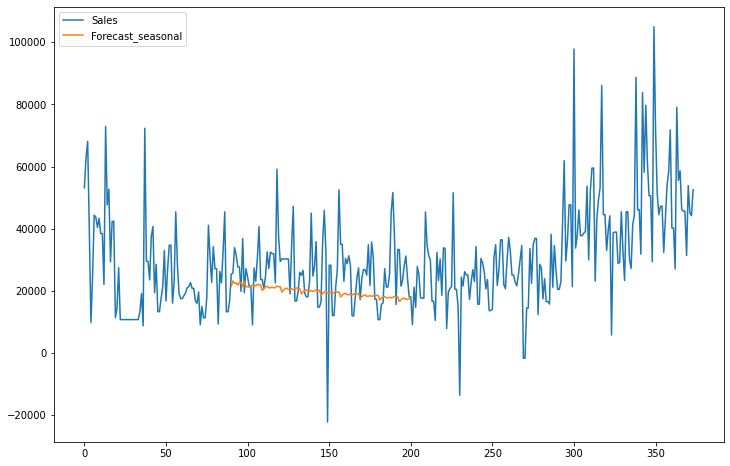

In [ ]:
sum_sales_train_df['Forecast_seasonal']=res.predict(start=90,end=200,dynamic=True)
sum_sales_train_df[['Sales','Forecast_seasonal']].plot(figsize=(12,8))